<a href="https://colab.research.google.com/github/saivenkatreddy29/Pytorch-Learning/blob/main/Replicating_papers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print('info: couldnt find torch info installing it')
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import datasetup,engine
  from helper_functions import download_data,set_seeds, plot_loss_curves
except:
  print('info: couldnt find the helper functions downloading them')
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves


info: couldnt find torch info installing it
info: couldnt find the helper functions downloading them
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4356 (delta 154), reused 119 (delta 119), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 32.84 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.
Updating files: 100% (248/248), done.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path/'train'
test_dir = image_path/'test'

Create Datasets and DataLoaders

In [ ]:
IMAGE_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
]
)
print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Turn images to Dataloaders


In [ ]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e6b2d2e1630>,
 ['pizza', 'steak', 'sushi'])

Visualize a Single Image

In [ ]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image = image_batch[0]
label = label_batch[0]



In [ ]:
print(image.shape)
per_image = image.permute(1,2,0)
print(per_image.shape)

torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


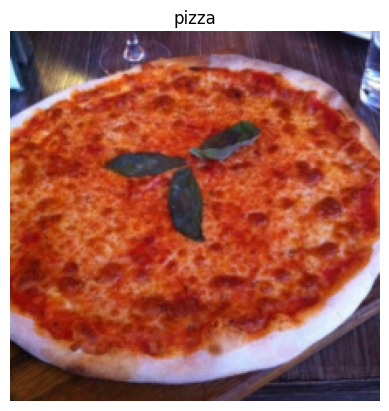

In [ ]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis('off');


Calculate path embedding input and output shapes

In [ ]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = (height*width)//(patch_size*patch_size)
print(f'number of patches:{number_of_patches}, height and width of patch:{patch_size}')

number of patches:196, height and width of patch:16


In [ ]:
embedding_layer_input_shape = (height,width,color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 2D flattened into patches):{embedding_layer_output_shape}')



Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D flattened into patches):(196, 768)


Turning Single image into patches

In [ ]:
per_image.shape

torch.Size([224, 224, 3])

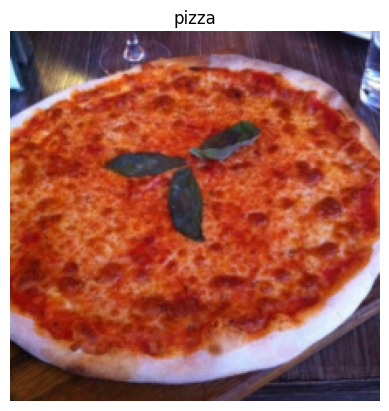

In [ ]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis(False);

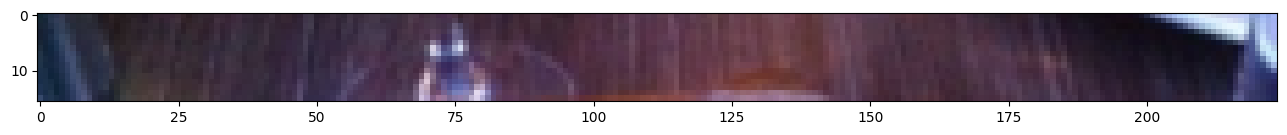

In [ ]:
patch_size = 16
plt.figure(figsize = (patch_size,patch_size))
plt.imshow(per_image[:patch_size,:,:]);

Number of patches per row :14.0: patch dim:16


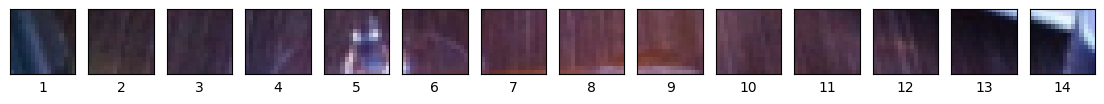

In [ ]:
img_size = 224
patch_size =16
num_patches = img_size/patch_size
assert img_size%patch_size ==0, "image must be divisiblbe by patch size"
print(f"Number of patches per row :{num_patches}: patch dim:{patch_size}")

fig,axs = plt.subplots(nrows = 1,
                       ncols = img_size//patch_size,
                       figsize = (num_patches,num_patches),
                       sharex = True,
                       sharey = True
                       )

for i, patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(per_image[:patch_size,patch:patch+patch_size,:]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


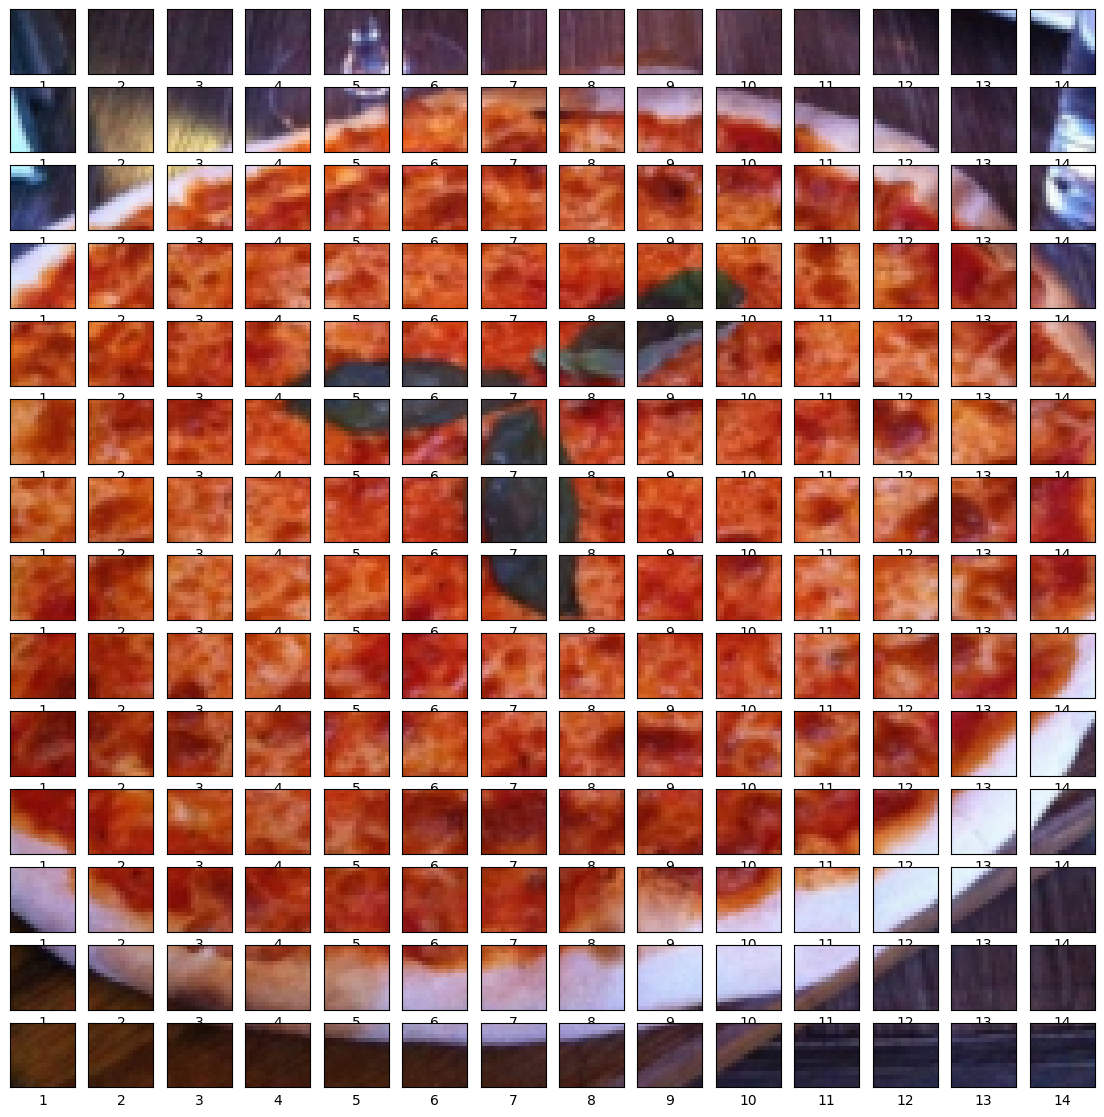

In [ ]:
num_rows = img_size//patch_size
fig,axs = plt.subplots(nrows = num_rows,
                       ncols = img_size//patch_size,
                       figsize = (num_patches,num_patches),
                       sharex = True,
                       sharey = True
                       )
for j,patch_height in enumerate(range(0,img_size,patch_size)):
  for i, patch in enumerate(range(0,img_size,patch_size)):
    axs[j,i].imshow(per_image[patch_height:patch_height+patch_size,patch:patch+patch_size,:]);
    axs[j,i].set_xlabel(i+1)
    axs[j,i].set_xticks([])
    axs[j,i].set_yticks([])

Creating iamge patches using torch.Conv2d()

In [ ]:
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(
    in_channels = 3,
    out_channels = 768,
    stride = patch_size,
    kernel_size = patch_size
)

In [ ]:
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

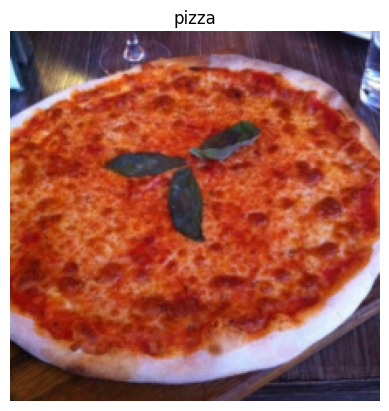

In [ ]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis(False);

In [ ]:
print(image.shape)
image_out_of_conv = conv2d(image.unsqueeze(dim = 0))
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


showing random conv feature maps of indexes:[595, 609, 212, 26, 649]


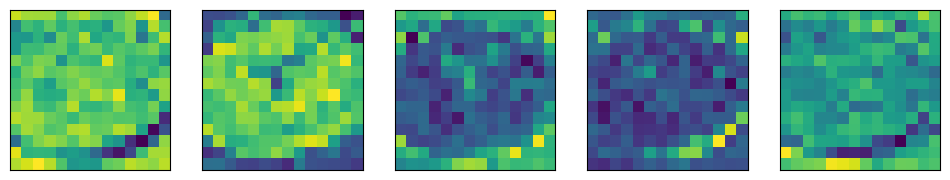

In [ ]:
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'showing random conv feature maps of indexes:{random_indexes}')

fig,axs = plt.subplots(nrows = 1,ncols = 5, figsize=(12,12))

for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels = [], yticklabels = [],xticks = [],yticks = []);

showing random conv feature maps of indexes:[351, 755, 725, 405, 244]


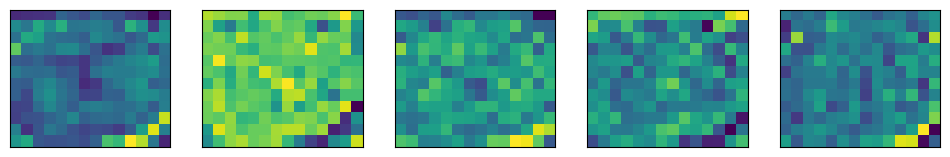

In [ ]:
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'showing random conv feature maps of indexes:{random_indexes}')

fig,axs = plt.subplots(nrows = 1,ncols = 5, figsize=(12,12))

for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:12,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels = [], yticklabels = [],xticks = [],yticks = []);

In [ ]:
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map.shape,single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

Flattening the path embedding with torch.nn.Flatten()

In [ ]:
print(f'current tensor shape :{image_out_of_conv.shape}')

current tensor shape :torch.Size([1, 768, 14, 14])


In [ ]:
flatten = nn.Flatten(start_dim =2,
                     end_dim = 3)

Original image shape:torch.Size([3, 224, 224])
image shape after conv is torch.Size([1, 768, 14, 14])
image after faltten is torch.Size([1, 768, 196])


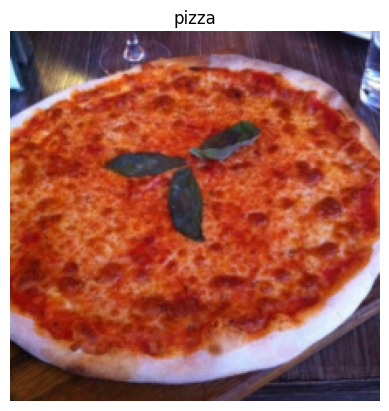

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f'Original image shape:{image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'image shape after conv is {image_out_of_conv.shape}')

image_flattened = flatten(image_out_of_conv)
print(f'image after faltten is {image_flattened.shape}')

In [ ]:
image_out_of_conv_flattened_reshaped = image_flattened.permute(0,2,1)
print(f'Patch embedding sequence shape:{image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]')

Patch embedding sequence shape:torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


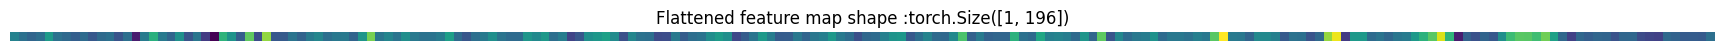

In [ ]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]

plt.figure(figsize = (22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape :{single_flattened_feature_map.shape}')
plt.axis(False);

Turning the VIT patch embedding layer into Pytorch module

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.in_channels = 3
    self.patch_size = 16
    self.embedding_dim = 768
    self.conv2d = nn.Conv2d(
        in_channels = self.in_channels,
        out_channels = self.embedding_dim,
        kernel_size = self.patch_size,
        stride = self.patch_size
    )
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)
  def forward(self,x):
    assert x.shape[-1] % self.patch_size == 0, f'Input size must be divisibel by patch size image:{x.shape} and patch:{self.patch_size}'
    x = self.conv2d(x)
    print(x.shape)

    x = self.flatten(x)
    return x.permute(0,2,1)


In [ ]:
embedding = PatchEmbedding()
flatten_output = embedding(image.unsqueeze(0))
print(flatten_output.shape)

torch.Size([1, 768, 14, 14])
torch.Size([1, 196, 768])


In [ ]:
random_input_image = (1,3,224,224)
summary(PatchEmbedding(),
        input_size = random_input_image,
        col_names =["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=['var_names'] )



torch.Size([1, 768, 14, 14])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (conv2d)                        [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

Creating the class tokens embedding

In [ ]:
print(flatten_output)
print(f'Patch embedding shape: {flatten_output.shape} -> [batch_size, number_of_patches, embedding_dimension]')

tensor([[[ 0.1853, -0.0253, -0.1282,  ...,  0.1008, -0.0383,  0.1956],
         [ 0.1381, -0.0424, -0.1061,  ...,  0.0352, -0.0476,  0.2003],
         [ 0.1352, -0.1050, -0.0818,  ...,  0.0635, -0.0482,  0.2033],
         ...,
         [ 0.1549, -0.0851, -0.1327,  ..., -0.0117, -0.0334,  0.1912],
         [ 0.1732, -0.0619, -0.1061,  ...,  0.0802, -0.0162,  0.2195],
         [ 0.1450, -0.0711, -0.1066,  ...,  0.0385, -0.0037,  0.2528]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
batch_size = flatten_output.shape[0]
embedding_dimension = flatten_output.shape[-1]

class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad = True
)

print(class_token[:,:,:10])
print(f'class token shape {class_token.shape} --> [batch_size, number of tokens, embedding dimension]')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class token shape torch.Size([1, 1, 768]) --> [batch_size, number of tokens, embedding dimension]


In [ ]:
embeddings_with_class_embedding = torch.cat((class_token, flatten_output),dim = 1)

print(embeddings_with_class_embedding)
print(f'Sequence of path embedding shape:{embeddings_with_class_embedding.shape} --> [batch_size, number_of_patchs, embedding_dimension]')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.1853, -0.0253, -0.1282,  ...,  0.1008, -0.0383,  0.1956],
         [ 0.1381, -0.0424, -0.1061,  ...,  0.0352, -0.0476,  0.2003],
         ...,
         [ 0.1549, -0.0851, -0.1327,  ..., -0.0117, -0.0334,  0.1912],
         [ 0.1732, -0.0619, -0.1061,  ...,  0.0802, -0.0162,  0.2195],
         [ 0.1450, -0.0711, -0.1066,  ...,  0.0385, -0.0037,  0.2528]]],
       grad_fn=<CatBackward0>)
Sequence of path embedding shape:torch.Size([1, 197, 768]) --> [batch_size, number_of_patchs, embedding_dimension]


Creating positional Embeddings

In [ ]:
number_of_patchs = int((height*width)/patch_size**2)

embedding_dimension = embeddings_with_class_embedding.shape[2]

positional_embedding = nn.Parameter(torch.ones(1,number_of_patchs+1,
                                               embedding_dimension),
                                    requires_grad = True)
print(positional_embedding[:,:10,:10])
print(f'the dimensiona are: {positional_embedding.shape}')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
the dimensiona are: torch.Size([1, 197, 768])


In [ ]:
# lets add them to the path embeddings
patch_and_positional_embeddings = embeddings_with_class_embedding + positional_embedding
print(patch_and_positional_embeddings)
print(f'Patch embeddings with position embeddings:{patch_and_positional_embeddings.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.1853, 0.9747, 0.8718,  ..., 1.1008, 0.9617, 1.1956],
         [1.1381, 0.9576, 0.8939,  ..., 1.0352, 0.9524, 1.2003],
         ...,
         [1.1549, 0.9149, 0.8673,  ..., 0.9883, 0.9666, 1.1912],
         [1.1732, 0.9381, 0.8939,  ..., 1.0802, 0.9838, 1.2195],
         [1.1450, 0.9289, 0.8934,  ..., 1.0385, 0.9963, 1.2528]]],
       grad_fn=<AddBackward0>)
Patch embeddings with position embeddings:torch.Size([1, 197, 768])


Putting all this together from image to embeddings

In [ ]:
set_seeds()

patch_size = 16
print(f'image tensor shape:{image.shape}')
height, width = image.shape[1],image.shape[2]

x = image.unsqueeze(dim = 0)
print(f' the dimensions of image sending in :{x.shape}')
patch_flattened_image = embedding(x)
print(f'the output of patch_flattend_image:{patch_flattened_image.shape}')

batch_size = 1
embedding_dimension = patch_flattened_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad = True)
print(f'class token embedding shape:{class_token.shape}')

patch_embedding_class_token = torch.cat((class_token,patch_flattened_image),dim = 1)
print(f'Patch embedding with class token shape {patch_embedding_class_token.shape}')

number_of_patches = int((height*width)/(patch_size**2))
position_embedding = nn.Parameter(torch.ones(batch_size,number_of_patches+1,embedding_dimension),
                                  requires_grad = True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape :{patch_and_position_embedding.shape}')


image tensor shape:torch.Size([3, 224, 224])
 the dimensions of image sending in :torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])
the output of patch_flattend_image:torch.Size([1, 196, 768])
class token embedding shape:torch.Size([1, 1, 768])
Patch embedding with class token shape torch.Size([1, 197, 768])
Patch and position embedding shape :torch.Size([1, 197, 768])


MultiHeaded self Attention and layer normalization

In [ ]:
class MultiHeadedSelfAttention(nn.Module):
  def __init__(self,embedding_dim = embedding_dimension,num_heads = 12,
               dropout = 0,
               ):
    super().__init__()
    self.layer_norm = torch.nn.LayerNorm(normalized_shape = embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = dropout,
                                                batch_first = True)

  def forward(self,x):
    x = self.layer_norm(x)
    attn_output, attn_weights = self.multihead_attn(
        query = x,
        key = x,
        value = x,
        need_weights = False
    )
    return attn_output


In [ ]:
self_attn = MultiHeadedSelfAttention()
attention_output = self_attn(patch_and_position_embedding)
print(f'the attention output shape:{attention_output.shape}')

the attention output shape:torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.1853, 0.9747, 0.8718,  ..., 1.1008, 0.9617, 1.1956],
         [1.1381, 0.9576, 0.8939,  ..., 1.0352, 0.9524, 1.2003],
         ...,
         [1.1549, 0.9149, 0.8673,  ..., 0.9883, 0.9666, 1.1912],
         [1.1732, 0.9381, 0.8939,  ..., 1.0802, 0.9838, 1.2195],
         [1.1450, 0.9289, 0.8934,  ..., 1.0385, 0.9963, 1.2528]]],
       grad_fn=<AddBackward0>)

In [ ]:
attention_output

tensor([[[ 0.5815, -0.2490, -0.2773,  ...,  0.7223, -0.4032, -0.0302],
         [ 0.6100, -0.2247, -0.2500,  ...,  0.7351, -0.4152, -0.0188],
         [ 0.6045, -0.2352, -0.2532,  ...,  0.7394, -0.4143, -0.0270],
         ...,
         [ 0.6008, -0.2389, -0.2599,  ...,  0.7386, -0.4072, -0.0235],
         [ 0.6063, -0.2341, -0.2547,  ...,  0.7385, -0.4100, -0.0219],
         [ 0.6091, -0.2321, -0.2486,  ...,  0.7364, -0.4141, -0.0254]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
class MLPLayer(nn.Module):
  def __init__(self, n_dim = 768,
               hidden_layer = 3072,
               dropout = 0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = n_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features =n_dim,
                  out_features = hidden_layer),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = hidden_layer,
                  out_features = n_dim),
        nn.Dropout(p=dropout),
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x


In [ ]:
mlp_block = MLPLayer(n_dim = 768,
                     hidden_layer = 3072,
                     dropout = 0.1)

patched_image_through_mlp = mlp_block(attention_output)
print(f'input to mlp layer:{attention_output.shape}')
print(f'output from mlp layer:{patched_image_through_mlp.shape}')



input to mlp layer:torch.Size([1, 197, 768])
output from mlp layer:torch.Size([1, 197, 768])


In [ ]:
attention_output


tensor([[[ 0.5815, -0.2490, -0.2773,  ...,  0.7223, -0.4032, -0.0302],
         [ 0.6100, -0.2247, -0.2500,  ...,  0.7351, -0.4152, -0.0188],
         [ 0.6045, -0.2352, -0.2532,  ...,  0.7394, -0.4143, -0.0270],
         ...,
         [ 0.6008, -0.2389, -0.2599,  ...,  0.7386, -0.4072, -0.0235],
         [ 0.6063, -0.2341, -0.2547,  ...,  0.7385, -0.4100, -0.0219],
         [ 0.6091, -0.2321, -0.2486,  ...,  0.7364, -0.4141, -0.0254]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
patched_image_through_mlp

tensor([[[ 0.3840,  0.0423,  0.2283,  ..., -0.1144,  0.1411, -0.1926],
         [ 0.2629, -0.0311,  0.1809,  ...,  0.0827,  0.1226, -0.0675],
         [ 0.3135, -0.1285,  0.2331,  ...,  0.0309,  0.1625, -0.2393],
         ...,
         [ 0.3369, -0.1344,  0.1771,  ...,  0.0741,  0.0000, -0.1344],
         [ 0.2744, -0.0618,  0.2814,  ..., -0.0000,  0.1495, -0.1426],
         [ 0.2354, -0.1000,  0.2571,  ...,  0.0600,  0.1598, -0.0000]]],
       grad_fn=<MulBackward0>)